<div style="background-color:powderblue;"><h1>Projet Synthese</h1><b>Groupe 3: Amardeepkumar Haulkhory, Hilaire Yuma, Jian-Guo Zhao, Mamadou Sy</b></div>

<h2>Partie II Apprentissage par <abbr title="Convolutional Neural Networks"><b>CNN </b></abbr></h2>
<p>Definir le <abbr title="Convolutional Neural Networks"><b>CNN </b></abbr>architecture:</p>
<ol>
<li>La premiere couche, Conv2D, prend un batch de donnees avec input_shape=(48,48,1)</li>
<li>La deuxieme couche, Conv2D, prend la sortie de couche 1, keras determine le shape automatiquement</li>
    <li>Il n'est pas necessaire d'indiquer input_shape pour les couches plus profondes</li>
    <li>La troisieme couche, Conv2D, prend la sortie de la couche 2, keras determine le shape automatiquement</li>
    <li>Ainsi de suite, on peut ajouter autres couches Conv2D s'il y en a besoin</li>
    <li>Entre chaque deux couches Conv2D, une couche Max pooling est ajoutee, pour bonne apprentissage</li>
    <li>Pour reduire le sur-apprentissage, une couche de regularisation Dropout pourrait etre ajoutee</li>
    <li>Pour une meilleur performance, une couche Normalisation pourrait etre aussi appliquee</li>
<li>Avant la couche dense, nous allons ajouter une couche Flatten qui convert le matrix 2D en vector 1D</li>
    <li>Puis, une couche Dense avec une fonction activation ReLu</li>
    <li>Encore une couche de regularization Dropout est appliquee</li>
    <li>Enfin, la couche de sortie donne 7 neurons pour les 7 classes avec une fonction activation softmax qui donne la possibilite de prediction pour chaque class.</li>
</ol>

<h3>Dependences - packages nécessaires</h3>
<p>En utilisant <b>tensorflow.compat.v1</b>, vous devez desactiver eager_execution.<br>Ce n'est pas le cas pour <b>tensorflow.v2</b>. De plus, le package <b>tensorflow</b> n'a pas la fonction <b><i>disable_eager_execution</i></b>.</p>

In [1]:
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_eager_execution()

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D 
from keras.utils import to_categorical

import numpy as np      # linear algebra
import pandas as pd     # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import os
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from numpy import expand_dims
from keras.preprocessing.image import img_to_array

%matplotlib inline

Using TensorFlow backend.


<h3>Chargement des donnees</h3>
<p>Pour eviter l'operation <b>download</b> des donnees se fait chaque fois, on les sauvegarde dans un repertoire local, qui est differente pour different colaborateurs. Veuillez changez la valeur de variable <b><i>data_dir</i></b> si necessaire</p>

In [2]:
# download the data from web and saved to local directory
# put the data in a variable make the following code usable for any data sources
# Original data is hold by df
data_dir = "C:\\Users\\jeang\\Documents\\BDEB\\A62\\ProSyn3\\data\\fer2013.csv"
df = pd.read_csv(data_dir )

<h3>Repartition des donnees</h3>
<p>Les donnees originales sont repartie en trois partie. Selons Partie I, la cible est bien balance dans ces trois parties</p>

In [3]:
df_training = df[df['Usage']=='Training']
df_PublicTest = df[df['Usage']=='PublicTest']
df_PrivateTest = df[df['Usage']=='PrivateTest']

<h3>Affichage des donnees</h3>
<p> Ces fonctions affichent un image (une ligne)<br>Notons que 48 x 48 = 2304</p>

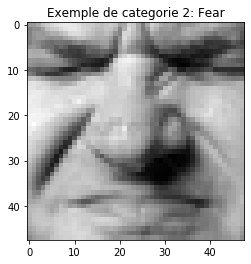

In [4]:
#import numpy as np
#import matplotlib.pyplot as plt

FER2013_WIDTH = 48
FER2013_HEIGHT = 48

# indices 0 - 6 correspondent emotions suivantes
Emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]  

def string_to_image(str_in):
    return np.reshape(str_in.split(" "), (FER2013_WIDTH, FER2013_HEIGHT)).astype("float")

def fer2013_show_instance(index, d=df):
    """Shows the image and the emotion label of the index's instance."""
    category, str_image = d.at[index,'emotion'], d.at[index,'pixels']
    image = string_to_image(str_image)
    plt.imshow(image, cmap="gray")
    plt.title(f"Exemple de categorie {category}: {Emotions[category]}")
    
fer2013_show_instance(np.random.randint(0,len(df_training)))

<h3>Fonction de transformation des données</h3>
<p><ul> La fonction <b><i>fer2013_to_4d_array</i></b> prend comme entree une dataframe qui tienne les donnees d'images en format des chaines de caracteres.<br>Elle retoune comme sortie un <b>np.array</b> de <mark>4 dimensions</mark>, normalisee, utilisables comme entree pour <b>tensorflow CNN<b></ul></p>

In [5]:
def fer2013_to_4d_array(d=df):
    """Transforms the (blank separated) pixel strings in the DataFrame to an 4-dimensional array 
    (1st dim: instances, 2nd and 3rd dims represent 2D image, 4th dim represent the color)."""
    
    pixels_list = d["pixels"].values
    list_image_2d = [string_to_image(pixels) for pixels in pixels_list]
        
    # Convert list to 4D array:
    X = np.expand_dims(np.array(list_image_2d), -1)
    print(f"The given data <pixel strings> has been converted to {X.shape} array")
    
    return X / 255

In [52]:
def image_to_4d_array(d=df):
    """Transforms the (blank separated) pixel strings in the DataFrame to an 4-dimensional array 
    (1st dim: instances, 2nd and 3rd dims represent 2D image, 4th dim represent the color)."""
    
    CLASS_NUMBER = 7
    pixels_list = d["pixels"].values
    list_image_2d = [string_to_image(pixels) for pixels in pixels_list]
        
    # Convert list to 4D array:
    X = np.expand_dims(np.array(list_image_2d), -1)
    X = X / 255
    
    Y = to_categorical(df_training.emotion, CLASS_NUMBER)
    
    print(f"The given data <pixel strings> has been converted to {X.shape} array")
    
    return X, Y

<p>On applique la fonction <b><i>fer2013_to_4d_array</i></b> sur les trois partitions</P>

In [6]:
X_train = fer2013_to_4d_array(df_training)
X_test = fer2013_to_4d_array(df_PrivateTest)
X_valid = fer2013_to_4d_array(df_PublicTest)

The given data <pixel strings> has been converted to (28709, 48, 48, 1) array
The given data <pixel strings> has been converted to (3589, 48, 48, 1) array
The given data <pixel strings> has been converted to (3589, 48, 48, 1) array


<h3>Fonction de transformation pour la cible</h3>
<p><ul>
    <li>La fonction <b style="backgroud-color:powerblue"><i>one_hot_label</i></b> prend comme entree une dataframe qui tienne les donnees d'emotions en format categoriel (7 classes).<br>Elle retoune comme sortie un <b>np.array</b> de <mark>2 dim</mark>. Les classes sont reparties en 7 colonnes, une pour chaque, utilisables pour <b>tensorflow<b></li>
    <li><b><mark>keras.utils.to_categorical</mark></b> peut faire le meme travail la sortie est du dtype float32</li>
</ul></p>

In [7]:
CLASS_NUMBER = 7
Y_train = to_categorical(df_training.emotion, CLASS_NUMBER)
Y_test = to_categorical(df_PrivateTest.emotion, CLASS_NUMBER)
Y_valid = to_categorical(df_PublicTest.emotion, CLASS_NUMBER)
Y_train[:5]

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

<h3>Fonction <i>show_confusion_matrix</i></h3>
<p><ul>
<li>Cette fonction <b style="backgroud-color:powerblue"><i>show_confusion_matrix</i></b> prend comme entree un modele</li>
    <li>Elle appelle la fonction <i style="color:blue">sklearn.metrics.confusion_matrix</i> en utilisant les donnees dans TestSet</li>
<li>pour retoune comme sortie un <b>pandas.DataFrame</b></li>
    </ul></p>

In [8]:
def show_confusion_matrix(model):
    submission = pd.DataFrame(model.predict(X_test))
    submission['label'] = submission.idxmax(axis=1)
    # y_pred = submission['label']
    # y_real = df_PrivateTest['emotion']
    cm = confusion_matrix(submission['label'], df_PrivateTest['emotion'])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = cm.round(2)
    return pd.DataFrame(cm)

<h3>Fonction <i>save_model</i></h3>
<p><ul>
<li>Cette fonction <b style="backgroud-color:powerblue"><i>save_model</i></b> prend comme entree un modele</li>
<li>Elle appelle <i style="color:blue">keras.models.to_json</i> et <i style="color:blue">keras.models.save_weights</i></li>
<li>Puis sauvegarde le modele et les poids dans deux fichies dont les nom sont fournies par utilisateur</li>
<li>Si soit le nom de fichier, soit le nom du repertoire, non fournie, elle utilise un nom par defaut</li>
    </ul></p>

In [9]:
def save_model(model, file_json="", file_weight="", workdir=""):
    # serialize model to JSON
    model_json = model.to_json()
    projet_dir = workdir if len(workdir)>0 else "C:\\Users\\jeang\\Documents\\BDEB\\A62\\ProSyn3"
    model_filename = 'fer.json' if file_json=="" else file_json
    with open(os.path.join(projet_dir, model_filename), "w") as json_file:
        json_file.write(model_json)

    # serialize weights to HDF5
    # model.save_weights("C:\\Users\\Nisha Haulkhory\\projet de synthese\\GIT\\ProSyn3\\fer.h5")
    weight_filename = 'fer.h5' if file_weight=="" else file_weight
    model.save_weights(os.path.join(projet_dir, weight_filename))
    print("Saved model to disk done")

<h3>Fonction <i>get_model_v20</i></h3>
<p><ul>
<li>Cette fonction <b style="backgroud-color:powerblue"><i>get_model_v20</i></b> peut prendre seulement quelques hyperparametres</li>
<li>Elle appelle <i style="color:blue">keras.models.Sequential</i> qui nous permet de construire un modele cnn</li>
<li>Les valeurs par defaut sont notre choix entre les meilleures, mais elle vous laisse la chance de les choisir</li>
<li>Elle retourne un architecture d'un modele Sequential qu'on peut l'entrainner et le tester</li>
</ul></p>

In [10]:
def get_model_v20(num_layers=5, 
                  num_filtre=(512,128,64,32,16), 
                  k_size=(3,3,3,3,3), 
                  p_size=(2,2,2,2,2), 
                  dropout=(0.2, 0.25, 0.3, 0.4, 0.5)):
    
    input_shape, num_classes = (48, 48, 1), 7
    model = Sequential()
    
    for layer in range(num_layers): 
        if layer == 0:
            model.add(Conv2D(num_filtre[layer], kernel_size=k_size[layer], activation=tf.nn.relu, padding="same", input_shape=input_shape))
        else:
            model.add(Conv2D(num_filtre[layer], kernel_size=k_size[layer], activation=tf.nn.relu, padding="same"))
            # normalization for each layer but not the first
            model.add(BatchNormalization())
        
        # max pooling with the given choose
        if p_size[layer] > 0:
            model.add(MaxPooling2D(pool_size=(p_size[layer], p_size[layer])))
        
        # Dropout with the given choose
        if dropout[layer] > 0:
            model.add(Dropout(dropout[layer]))           
        

    model.add(Flatten())                          # Flattening the 2D arrays for fully connected layers
    model.add(Dense(32, activation=tf.nn.relu))
    model.add(Dropout(dropout[-1]))
    model.add(Dense(num_classes,activation=tf.nn.softmax))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

<h3>Fonction <i>fit_test_save_hist</i></h3>
<p><ul>
<li>Cette fonction <b style="backgroud-color:powerblue"><i>fit_test_save_hist</i></b> prend comme entree un modele cnn et quelques hyperparametres</li>
<li>Elle appelle <i style="color:blue">keras.models.Sequential.fit</i> pour apprendre le modele cnn</li>
    <li>Elle affiche l'evolution d'apprentissage en utilisant <i style="color:blue">seaborn.lineplot</i></li>
<li>Puis, elle appelle <i style="color:blue">keras.models.Sequential.evaluate</i> pour tester le modele
<li>Elle retourne l'histoire d'apprentissage du modele et le resultat du test avec les donnees TestSet</li>
    <li>Ceci presente un avantage si on decide continue l'apprentissage</li>    
<li>Les valeurs par defaut vous donne la possibilite de les choisir</li>
    </ul></p>

In [11]:
def fit_test_save_hist(model, x_train=X_train, y_train=Y_train, valid=(X_valid, Y_valid), 
                       bs=128, ep=30, fnm='fer.json', fnw='fer.h5'):
    print("Fitting the model with new train set and new validation set ...")
    l = model.fit(x=x_train, y=y_train, validation_data=valid, batch_size=bs, epochs=ep)
    sns.lineplot(data=pd.DataFrame(l.history)[['accuracy','val_accuracy']], palette="tab10", linewidth=2.5);
    save_model(model, file_json=fnm, file_weight=fnw)
    print("Evaluating the model on test data ...")
    results = model.evaluate(X_test, Y_test)
    print("test loss, test acc:", results)
    print(show_confusion_matrix(model))
    return l, results

<h3>Appliquer la <i style="color:blue">fonction get_model_v20</i></h3>

In [12]:
model = get_model_v20(dropout=(0.2,0.2,0.25,0.25,0.30))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 512)       5120      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 512)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 512)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       589952    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       512       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 128)      

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/30
28709/28709 [==============================] - 667s 23ms/step - loss: 1.9086 - accuracy: 0.2205 - val_loss: 1.7909 - val_accuracy: 0.2488
Epoch 2/30
28709/28709 [==============================] - 665s 23ms/step - loss: 1.8026 - accuracy: 0.2498 - val_loss: 1.8026 - val_accuracy: 0.2611
Epoch 3/30
28709/28709 [==============================] - 662s 23ms/step - loss: 1.7811 - accuracy: 0.2597 - val_loss: 1.8124 - val_accuracy: 0.2605
Epoch 4/30
28709/28709 [==============================] - 663s 23ms/step - loss: 1.7174 - accuracy: 0.2995 - val_loss: 1.6739 - val_accuracy: 0.3271
Epoch 5/30
28709/28709 [==============================] - 659s 23ms/step - loss: 1.6057 - accuracy: 0.3672 - val_loss: 1.5444 - val_accuracy: 0.4032
Epoch 6/30
28709/28709 [==============================] - 659s 23ms/step - loss: 1.5404 - accuracy: 0.3971 - val_loss: 1.5203 - val_accuracy: 

C:\Users\jeang\anaconda3\envs\rl_env\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


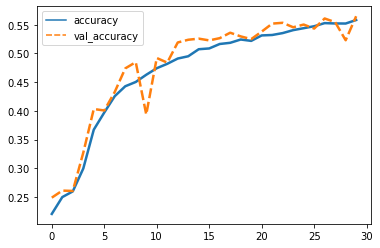

In [13]:
h4, r4 = fit_test_save_hist(model, bs=64, fnm='fer24.json', fnw='fer24.h5')

In [14]:
model = get_model_v20(dropout=(0.2,0.2,0.2,0.25,0.25))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 512)       5120      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 512)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 24, 24, 512)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 128)       589952    
_________________________________________________________________
batch_normalization_5 (Batch (None, 24, 24, 128)       512       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 12, 12, 128)      

<p>Nous cherchons la valeur maximum du hyperparametre bs, sachant que 128 entraine des crash de l'ordinateur et 64 ne peut pas detecter class 1, qui a environ 1% population. Nous commencons par 96</p>

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/20
28709/28709 [==============================] - 692s 24ms/step - loss: 1.9079 - accuracy: 0.2224 - val_loss: 1.8400 - val_accuracy: 0.2455
Epoch 2/20
28709/28709 [==============================] - 688s 24ms/step - loss: 1.8009 - accuracy: 0.2543 - val_loss: 1.8000 - val_accuracy: 0.2561
Epoch 3/20
28709/28709 [==============================] - 686s 24ms/step - loss: 1.7368 - accuracy: 0.2975 - val_loss: 1.9288 - val_accuracy: 0.2065
Epoch 4/20
28709/28709 [==============================] - 684s 24ms/step - loss: 1.6303 - accuracy: 0.3524 - val_loss: 1.9070 - val_accuracy: 0.2736
Epoch 5/20
28709/28709 [==============================] - 692s 24ms/step - loss: 1.5816 - accuracy: 0.3803 - val_loss: 1.5637 - val_accuracy: 0.3937
Epoch 6/20
28709/28709 [==============================] - 711s 25ms/step - loss: 1.5195 - accuracy: 0.4090 - val_loss: 1.4699 - val_accuracy: 

C:\Users\jeang\anaconda3\envs\rl_env\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


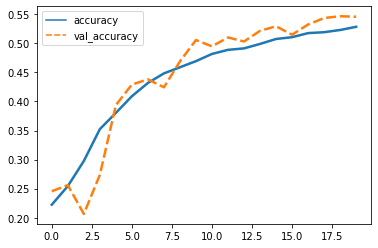

In [15]:
h5, r5 = fit_test_save_hist(model, bs=96, ep=20, fnm='fer25.json', fnw='fer25.h5')

<p>On a pas de problem over-fitting avec ce model et mon ordi a bien fini son travail sans lacher, mais le problem de class 1 est encore la. Testons donc bs = 112 pour avoir un maximum value bs et meilleur performance</p> 

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 680s 24ms/step - loss: 1.2282 - accuracy: 0.5362 - val_loss: 1.1672 - val_accuracy: 0.5539
Epoch 2/10
28709/28709 [==============================] - 695s 24ms/step - loss: 1.2196 - accuracy: 0.5416 - val_loss: 1.2022 - val_accuracy: 0.5344
Epoch 3/10
28709/28709 [==============================] - 709s 25ms/step - loss: 1.2179 - accuracy: 0.5398 - val_loss: 1.1692 - val_accuracy: 0.5567
Epoch 4/10
28709/28709 [==============================] - 696s 24ms/step - loss: 1.2087 - accuracy: 0.5455 - val_loss: 1.1562 - val_accuracy: 0.5614
Epoch 5/10
28709/28709 [==============================] - 698s 24ms/step - loss: 1.1998 - accuracy: 0.5503 - val_loss: 1.1856 - val_accuracy: 0.5511
Epoch 6/10
28709/28709 [==============================] - 686s 24ms/step - loss: 1.1960 - accuracy: 0.5520 - val_loss: 1.1752 - val_accuracy: 

C:\Users\jeang\anaconda3\envs\rl_env\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


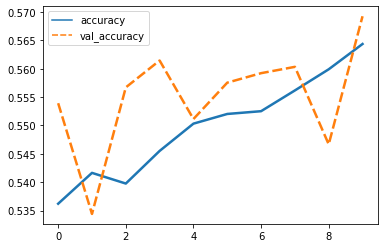

In [16]:
h6, r6 = fit_test_save_hist(model, bs=112, ep=10, fnm='fer26.json', fnw='fer26.h5')

In [17]:
proba = pd.DataFrame(model.predict(X_test))
y_pred = proba.idxmax(axis=1)


AttributeError: 'numpy.ndarray' object has no attribute 'idxmax'

In [20]:
y_pred[y_pred==1]

Series([], dtype: int64)

In [18]:
y_real = pd.DataFrame(Y_test).idxmax(axis=1)

In [21]:
y_real[y_real==1]

34      1
178     1
189     1
227     1
233     1
248     1
383     1
419     1
614     1
625     1
706     1
911     1
986     1
1064    1
1085    1
1089    1
1183    1
1245    1
1263    1
1363    1
1372    1
1466    1
1486    1
1549    1
1672    1
1676    1
1697    1
1724    1
1770    1
1775    1
1828    1
1909    1
2125    1
2134    1
2207    1
2221    1
2295    1
2324    1
2389    1
2394    1
2482    1
2495    1
2649    1
2650    1
2660    1
2717    1
2998    1
3014    1
3078    1
3093    1
3108    1
3111    1
3282    1
3488    1
3543    1
dtype: int64

In [19]:
    # y_pred = submission['label']
    # y_real = df_PrivateTest['emotion']
#cm = confusion_matrix(submission['label'], df_PrivateTest['emotion'])
cm = confusion_matrix(y_pred, y_real)
pd.DataFrame(cm)
    #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #cm = cm.round(2)
    #return pd.DataFrame(cm)

,0,1,2,3,4,5,6
0,196,27,64,10,48,6,18
1,0,0,0,0,0,0,0
2,23,2,68,8,19,29,5
3,58,8,62,784,68,45,89
4,106,12,148,34,307,10,107
5,8,3,78,12,6,299,4
6,100,3,108,31,146,27,403


In [22]:
model = get_model_v20(p_size=(2,2,2,2,0), dropout=(0.2, 0.2, 0.2, 0.2, 0.25))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 48, 48, 512)       5120      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 24, 24, 512)       0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 24, 24, 512)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 128)       589952    
_________________________________________________________________
batch_normalization_9 (Batch (None, 24, 24, 128)       512       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 12, 12, 128)      

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 696s 24ms/step - loss: 1.9038 - accuracy: 0.2296 - val_loss: 1.8319 - val_accuracy: 0.2494
Epoch 2/10
28709/28709 [==============================] - 727s 25ms/step - loss: 1.7934 - accuracy: 0.2621 - val_loss: 1.8247 - val_accuracy: 0.2588
Epoch 3/10
28709/28709 [==============================] - 718s 25ms/step - loss: 1.7368 - accuracy: 0.2961 - val_loss: 1.9410 - val_accuracy: 0.2471
Epoch 4/10
28709/28709 [==============================] - 707s 25ms/step - loss: 1.6523 - accuracy: 0.3446 - val_loss: 1.7053 - val_accuracy: 0.3360
Epoch 5/10
28709/28709 [==============================] - 698s 24ms/step - loss: 1.5566 - accuracy: 0.3900 - val_loss: 1.6807 - val_accuracy: 0.3452
Epoch 6/10
28709/28709 [==============================] - 694s 24ms/step - loss: 1.4886 - accuracy: 0.4171 - val_loss: 1.5726 - val_accuracy: 

C:\Users\jeang\anaconda3\envs\rl_env\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


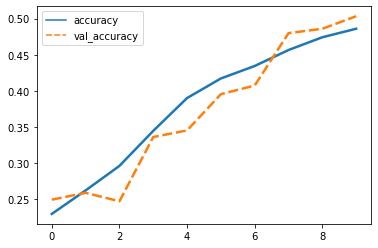

In [23]:
h7, r7 = fit_test_save_hist(model, bs=128, ep=10, fnm='fer27.json', fnw='fer27.h5')

In [24]:
proba = pd.DataFrame(model.predict(X_test))
y_pred = proba.idxmax(axis=1)
y_pred[y_pred==1]

Series([], dtype: int64)

In [39]:
def get_model_v40(num_layers=5, lf = 128,
                  num_filtre=(16, 32, 64, 128, 256), 
                  k_size=(3,3,3,3,3), 
                  p_size=(2,2,2,2,0), 
                  dropout=(0.0, 0.0, 0.5, 0.0, 0.0)):
    
    input_shape, num_classes, last_features = (48, 48, 1), 7, lf
    model = Sequential()
    
    for layer in range(num_layers): 
        if layer == 0:
            model.add(Conv2D(num_filtre[layer], kernel_size=k_size[layer], activation=tf.nn.relu, padding="same", input_shape=input_shape))
        else:
            model.add(Conv2D(num_filtre[layer], kernel_size=k_size[layer], activation=tf.nn.relu, padding="same"))
            # normalization for each layer but not the first
            model.add(BatchNormalization())
        
        # max pooling with the given choose
        if p_size[layer] > 0:
            model.add(MaxPooling2D(pool_size=(p_size[layer], p_size[layer])))
        
        # Dropout with the given choose
        if dropout[layer] > 0:
            model.add(Dropout(dropout[layer]))           
        

    model.add(Flatten())                          # Flattening the 2D arrays for fully connected layers
    model.add(Dense(last_features, activation=tf.nn.relu))
    last_dropout = dropout[-1]
    if last_dropout < 0.5:
        last_dropout = 0.5
    model.add(Dropout(dropout[-1]))
    model.add(Dense(num_classes, activation=tf.nn.softmax))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [25]:
def get_model_v30(num_layers=5, 
                  num_filtre=(32, 64, 128, 256, 512), 
                  k_size=(3,3,3,3,3), 
                  p_size=(2,2,2,2,0), 
                  dropout=(0.0, 0.0, 0.0, 0.0, 0.25)):
    
    input_shape, num_classes = (48, 48, 1), 7
    model = Sequential()
    
    for layer in range(num_layers): 
        if layer == 0:
            model.add(Conv2D(num_filtre[layer], kernel_size=k_size[layer], activation=tf.nn.relu, padding="same", input_shape=input_shape))
        else:
            model.add(Conv2D(num_filtre[layer], kernel_size=k_size[layer], activation=tf.nn.relu, padding="same"))
            # normalization for each layer but not the first
            model.add(BatchNormalization())
        
        # max pooling with the given choose
        if p_size[layer] > 0:
            model.add(MaxPooling2D(pool_size=(p_size[layer], p_size[layer])))
        
        # Dropout with the given choose
        if dropout[layer] > 0:
            model.add(Dropout(dropout[layer]))           
        

    model.add(Flatten())                          # Flattening the 2D arrays for fully connected layers
    model.add(Dense(32, activation=tf.nn.relu))
    last_dropout = dropout[-1]
    if last_dropout < 0.5:
        last_dropout = 0.5
    model.add(Dropout(dropout[-1]))
    model.add(Dense(num_classes, activation=tf.nn.softmax))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [27]:
model = get_model_v30(num_filtre=(32, 64, 64, 128, 128), p_size=(2,2,2,2,0), dropout=(0.0, 0.0, 0.25, 0.0, 0.0))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_17 (Batc (None, 24, 24, 64)        256       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
batch_normalization_18 (Batc (None, 12, 12, 64)       

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 76s 3ms/step - loss: 1.6856 - accuracy: 0.3219 - val_loss: 2.6223 - val_accuracy: 0.0471
Epoch 2/10
28709/28709 [==============================] - 75s 3ms/step - loss: 1.4403 - accuracy: 0.4391 - val_loss: 1.8322 - val_accuracy: 0.2288
Epoch 3/10
28709/28709 [==============================] - 76s 3ms/step - loss: 1.3083 - accuracy: 0.4912 - val_loss: 1.3457 - val_accuracy: 0.4706
Epoch 4/10
28709/28709 [==============================] - 76s 3ms/step - loss: 1.2056 - accuracy: 0.5386 - val_loss: 1.2805 - val_accuracy: 0.5040
Epoch 5/10
28709/28709 [==============================] - 75s 3ms/step - loss: 1.1239 - accuracy: 0.5688 - val_loss: 1.2551 - val_accuracy: 0.5213
Epoch 6/10
28709/28709 [==============================] - 76s 3ms/step - loss: 1.0555 - accuracy: 0.5980 - val_loss: 1.3683 - val_accuracy: 0.4951
Epoch

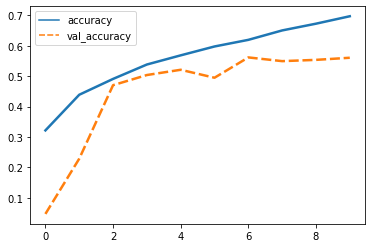

In [28]:
h8, r8 = fit_test_save_hist(model, bs=128, ep=10, fnm='fer28.json', fnw='fer28.h5')

In [30]:
model = get_model_v30(num_filtre=(16, 32, 64, 128, 256), p_size=(2,2,2,2,0), dropout=(0.10, 0.10, 0.2, 0.1, 0.1))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
batch_normalization_25 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 12, 12, 32)       

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 51s 2ms/step - loss: 1.8224 - accuracy: 0.2470 - val_loss: 1.9000 - val_accuracy: 0.2463
Epoch 2/10
28709/28709 [==============================] - 49s 2ms/step - loss: 1.7089 - accuracy: 0.3149 - val_loss: 1.7532 - val_accuracy: 0.2527
Epoch 3/10
28709/28709 [==============================] - 49s 2ms/step - loss: 1.5863 - accuracy: 0.3580 - val_loss: 1.5461 - val_accuracy: 0.3792
Epoch 4/10
28709/28709 [==============================] - 49s 2ms/step - loss: 1.5119 - accuracy: 0.3874 - val_loss: 1.4177 - val_accuracy: 0.4210
Epoch 5/10
28709/28709 [==============================] - 48s 2ms/step - loss: 1.4505 - accuracy: 0.4051 - val_loss: 1.4464 - val_accuracy: 0.4283
Epoch 6/10
28709/28709 [==============================] - 49s 2ms/step - loss: 1.4069 - accuracy: 0.4274 - val_loss: 1.4501 - val_accuracy: 0.4366
Epoch

C:\Users\jeang\anaconda3\envs\rl_env\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


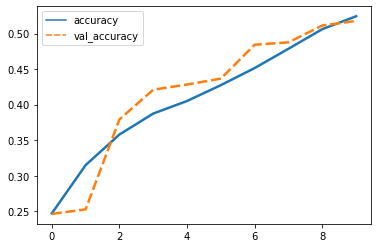

In [31]:
h9, r9 = fit_test_save_hist(model, bs=128, ep=10, fnm='fer29.json', fnw='fer29.h5')

In [32]:
model = get_model_v30(num_filtre=(16, 32, 64, 128, 256), p_size=(2,2,2,2,0), dropout=(0.0, 0.0, 0.25, 0.0, 0.0))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
batch_normalization_29 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_30 (Batc (None, 12, 12, 64)       

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 47s 2ms/step - loss: 1.6953 - accuracy: 0.3161 - val_loss: 2.2266 - val_accuracy: 0.1379
Epoch 2/10
28709/28709 [==============================] - 46s 2ms/step - loss: 1.4513 - accuracy: 0.4361 - val_loss: 1.5981 - val_accuracy: 0.3817
Epoch 3/10
28709/28709 [==============================] - 47s 2ms/step - loss: 1.3279 - accuracy: 0.4793 - val_loss: 1.3881 - val_accuracy: 0.4670
Epoch 4/10
28709/28709 [==============================] - 48s 2ms/step - loss: 1.2438 - accuracy: 0.5173 - val_loss: 1.3183 - val_accuracy: 0.4893
Epoch 5/10
28709/28709 [==============================] - 46s 2ms/step - loss: 1.1583 - accuracy: 0.5542 - val_loss: 1.3597 - val_accuracy: 0.4976
Epoch 6/10
28709/28709 [==============================] - 46s 2ms/step - loss: 1.0899 - accuracy: 0.5854 - val_loss: 1.2556 - val_accuracy: 0.5291
Epoch

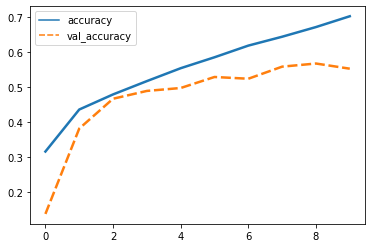

In [33]:
h1, r1 = fit_test_save_hist(model, bs=128, ep=10, fnm='fer31.json', fnw='fer31.h5')

In [34]:
model = get_model_v30(num_filtre=(16, 32, 64, 128, 256), p_size=(2,2,2,2,0), dropout=(0.0, 0.0, 0.5, 0.0, 0.0))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
batch_normalization_33 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_34 (Batc (None, 12, 12, 64)       

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 47s 2ms/step - loss: 1.7203 - accuracy: 0.3149 - val_loss: 7.6928 - val_accuracy: 0.0156
Epoch 2/10
28709/28709 [==============================] - 47s 2ms/step - loss: 1.5158 - accuracy: 0.4057 - val_loss: 2.5887 - val_accuracy: 0.2522
Epoch 3/10
28709/28709 [==============================] - 47s 2ms/step - loss: 1.4078 - accuracy: 0.4506 - val_loss: 1.4639 - val_accuracy: 0.4316
Epoch 4/10
28709/28709 [==============================] - 45s 2ms/step - loss: 1.3376 - accuracy: 0.4776 - val_loss: 1.4415 - val_accuracy: 0.4344
Epoch 5/10
28709/28709 [==============================] - 45s 2ms/step - loss: 1.2815 - accuracy: 0.5010 - val_loss: 1.3975 - val_accuracy: 0.4731
Epoch 6/10
28709/28709 [==============================] - 45s 2ms/step - loss: 1.2388 - accuracy: 0.5217 - val_loss: 1.2988 - val_accuracy: 0.5001
Epoch

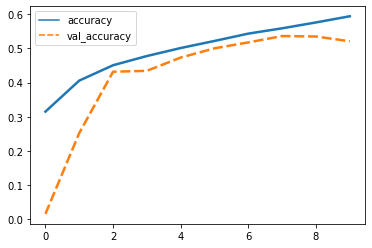

In [35]:
h2, r2 = fit_test_save_hist(model, bs=128, ep=10, fnm='fer32.json', fnw='fer32.h5')

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 44s 2ms/step - loss: 1.0076 - accuracy: 0.6178 - val_loss: 1.1890 - val_accuracy: 0.5587
Epoch 2/10
28709/28709 [==============================] - 44s 2ms/step - loss: 0.9668 - accuracy: 0.6367 - val_loss: 1.2926 - val_accuracy: 0.5461
Epoch 3/10
28709/28709 [==============================] - 45s 2ms/step - loss: 0.9336 - accuracy: 0.6462 - val_loss: 1.2534 - val_accuracy: 0.5795
Epoch 4/10
28709/28709 [==============================] - 44s 2ms/step - loss: 0.9073 - accuracy: 0.6583 - val_loss: 1.3264 - val_accuracy: 0.5667
Epoch 5/10
28709/28709 [==============================] - 44s 2ms/step - loss: 0.8603 - accuracy: 0.6777 - val_loss: 1.2388 - val_accuracy: 0.5782
Epoch 6/10
28709/28709 [==============================] - 44s 2ms/step - loss: 0.8321 - accuracy: 0.6875 - val_loss: 1.5474 - val_accuracy: 0.5366
Epoch

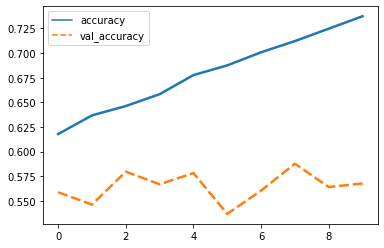

In [36]:
h3, r3 = fit_test_save_hist(model, bs=192, ep=10, fnm='fer33.json', fnw='fer33.h5')

In [37]:
model = get_model_v30(num_filtre=(16, 32, 64, 128, 256), p_size=(2,2,2,2,0), dropout=(0.0, 0.0, 0.5, 0.0, 0.5))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
batch_normalization_37 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_38 (Batc (None, 12, 12, 64)      

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 49s 2ms/step - loss: 1.9565 - accuracy: 0.2440 - val_loss: 2.0108 - val_accuracy: 0.2494
Epoch 2/10
28709/28709 [==============================] - 47s 2ms/step - loss: 1.8755 - accuracy: 0.2555 - val_loss: 2.1126 - val_accuracy: 0.2466
Epoch 3/10
28709/28709 [==============================] - 46s 2ms/step - loss: 1.8254 - accuracy: 0.2599 - val_loss: 1.8877 - val_accuracy: 0.2315
Epoch 4/10
28709/28709 [==============================] - 47s 2ms/step - loss: 1.7950 - accuracy: 0.2587 - val_loss: 1.7591 - val_accuracy: 0.2510
Epoch 5/10
28709/28709 [==============================] - 48s 2ms/step - loss: 1.7409 - accuracy: 0.2830 - val_loss: 1.6781 - val_accuracy: 0.3221
Epoch 6/10
28709/28709 [==============================] - 46s 2ms/step - loss: 1.7078 - accuracy: 0.3051 - val_loss: 1.6702 - val_accuracy: 0.3580
Epoch

C:\Users\jeang\anaconda3\envs\rl_env\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


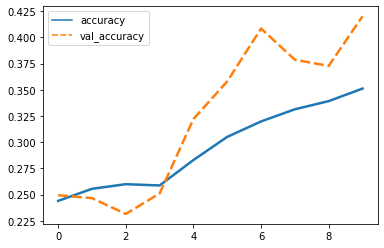

In [38]:
h1, r1 = fit_test_save_hist(model, bs=256, ep=10, fnm='fer34.json', fnw='fer34.h5')

In [41]:
model = get_model_v40(p_size=(2,2,2,2,2))
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
batch_normalization_45 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_46 (Batc (None, 12, 12, 64)      

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 48s 2ms/step - loss: 1.7667 - accuracy: 0.2923 - val_loss: 2.1436 - val_accuracy: 0.1691
Epoch 2/10
28709/28709 [==============================] - 47s 2ms/step - loss: 1.5366 - accuracy: 0.4035 - val_loss: 2.7577 - val_accuracy: 0.1775
Epoch 3/10
28709/28709 [==============================] - 48s 2ms/step - loss: 1.4034 - accuracy: 0.4577 - val_loss: 2.6195 - val_accuracy: 0.1775
Epoch 4/10
28709/28709 [==============================] - 47s 2ms/step - loss: 1.3211 - accuracy: 0.4924 - val_loss: 1.9484 - val_accuracy: 0.2547
Epoch 5/10
28709/28709 [==============================] - 46s 2ms/step - loss: 1.2610 - accuracy: 0.5159 - val_loss: 1.9868 - val_accuracy: 0.2758
Epoch 6/10
28709/28709 [==============================] - 46s 2ms/step - loss: 1.2059 - accuracy: 0.5420 - val_loss: 1.4161 - val_accuracy: 0.4692
Epoch

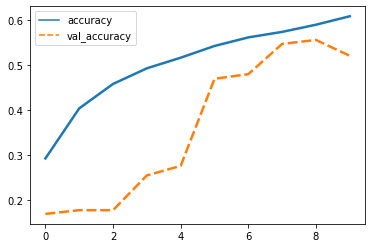

In [42]:
h1, r1 = fit_test_save_hist(model, bs=256, ep=10, fnm='fer40.json', fnw='fer40.h5')

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 47s 2ms/step - loss: 1.0114 - accuracy: 0.6167 - val_loss: 1.2384 - val_accuracy: 0.5511
Epoch 2/10
28709/28709 [==============================] - 48s 2ms/step - loss: 0.9795 - accuracy: 0.6318 - val_loss: 1.2179 - val_accuracy: 0.5500
Epoch 3/10
28709/28709 [==============================] - 48s 2ms/step - loss: 0.9495 - accuracy: 0.6427 - val_loss: 1.2282 - val_accuracy: 0.5528
Epoch 4/10
28709/28709 [==============================] - 47s 2ms/step - loss: 0.9156 - accuracy: 0.6563 - val_loss: 1.2504 - val_accuracy: 0.5645
Epoch 5/10
28709/28709 [==============================] - 47s 2ms/step - loss: 0.8738 - accuracy: 0.6729 - val_loss: 1.1881 - val_accuracy: 0.5575
Epoch 6/10
28709/28709 [==============================] - 46s 2ms/step - loss: 0.8476 - accuracy: 0.6834 - val_loss: 1.3961 - val_accuracy: 0.5352
Epoch

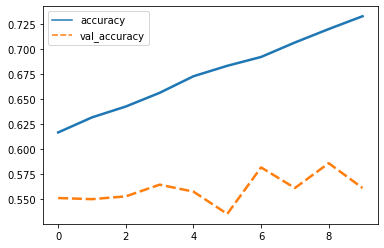

In [43]:
h2, r2 = fit_test_save_hist(model, bs=256, ep=10, fnm='fer41.json', fnw='fer41.h5')

In [44]:
model = get_model_v40(p_size=(2,2,2,2,2), dropout=(0,0,0,0,0.6))
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
batch_normalization_49 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_50 (Batc (None, 12, 12, 64)      

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 48s 2ms/step - loss: 2.1888 - accuracy: 0.2128 - val_loss: 2.3018 - val_accuracy: 0.1797
Epoch 2/10
28709/28709 [==============================] - 47s 2ms/step - loss: 1.8229 - accuracy: 0.2472 - val_loss: 2.5218 - val_accuracy: 0.2497
Epoch 3/10
28709/28709 [==============================] - 46s 2ms/step - loss: 1.7389 - accuracy: 0.2952 - val_loss: 2.0733 - val_accuracy: 0.2705
Epoch 4/10
28709/28709 [==============================] - 47s 2ms/step - loss: 1.6361 - accuracy: 0.3465 - val_loss: 1.7300 - val_accuracy: 0.3043
Epoch 5/10
28709/28709 [==============================] - 46s 2ms/step - loss: 1.5413 - accuracy: 0.3912 - val_loss: 2.0623 - val_accuracy: 0.3728
Epoch 6/10
28709/28709 [==============================] - 46s 2ms/step - loss: 1.4720 - accuracy: 0.4203 - val_loss: 1.5416 - val_accuracy: 0.4244
Epoch

C:\Users\jeang\anaconda3\envs\rl_env\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


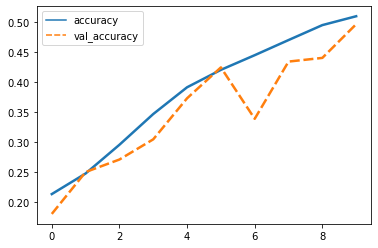

In [45]:
h2, r2 = fit_test_save_hist(model, bs=256, ep=10, fnm='fer42.json', fnw='fer42.h5')

In [46]:
model = get_model_v40(p_size=(2,2,2,2,2), dropout=(0,0,0.6,0,0))
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
batch_normalization_53 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_54 (Batc (None, 12, 12, 64)      

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 48s 2ms/step - loss: 1.8150 - accuracy: 0.2748 - val_loss: 2.2434 - val_accuracy: 0.1382
Epoch 2/10
28709/28709 [==============================] - 48s 2ms/step - loss: 1.6168 - accuracy: 0.3642 - val_loss: 2.4419 - val_accuracy: 0.1368
Epoch 3/10
28709/28709 [==============================] - 47s 2ms/step - loss: 1.4944 - accuracy: 0.4220 - val_loss: 2.6768 - val_accuracy: 0.1783
Epoch 4/10
28709/28709 [==============================] - 48s 2ms/step - loss: 1.4107 - accuracy: 0.4589 - val_loss: 1.8589 - val_accuracy: 0.2956
Epoch 5/10
28709/28709 [==============================] - 48s 2ms/step - loss: 1.3443 - accuracy: 0.4855 - val_loss: 1.5981 - val_accuracy: 0.4099
Epoch 6/10
28709/28709 [==============================] - 48s 2ms/step - loss: 1.2873 - accuracy: 0.5056 - val_loss: 1.5911 - val_accuracy: 0.4374
Epoch

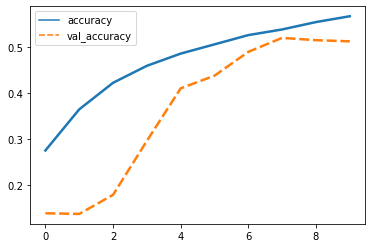

In [47]:
h2, r2 = fit_test_save_hist(model, bs=256, ep=10, fnm='fer43.json', fnw='fer43.h5')

In [48]:
model = get_model_v40(p_size=(2,2,2,2,2), dropout=(0,0.3,0.0,0.3,0))
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
batch_normalization_57 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 12, 12, 64)      

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 54s 2ms/step - loss: 1.8237 - accuracy: 0.2814 - val_loss: 3.0871 - val_accuracy: 0.0156
Epoch 2/10
28709/28709 [==============================] - 54s 2ms/step - loss: 1.5870 - accuracy: 0.3829 - val_loss: 2.2061 - val_accuracy: 0.1691
Epoch 3/10
28709/28709 [==============================] - 52s 2ms/step - loss: 1.4712 - accuracy: 0.4342 - val_loss: 2.8903 - val_accuracy: 0.1691
Epoch 4/10
28709/28709 [==============================] - 53s 2ms/step - loss: 1.3763 - accuracy: 0.4722 - val_loss: 2.2139 - val_accuracy: 0.2115
Epoch 5/10
28709/28709 [==============================] - 52s 2ms/step - loss: 1.3131 - accuracy: 0.5001 - val_loss: 1.6080 - val_accuracy: 0.3806
Epoch 6/10
28709/28709 [==============================] - 52s 2ms/step - loss: 1.2481 - accuracy: 0.5250 - val_loss: 1.3041 - val_accuracy: 0.5060
Epoch

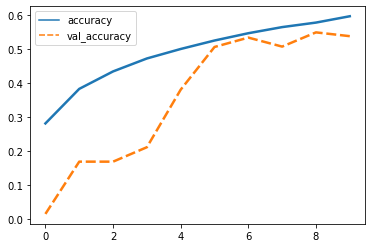

In [49]:
h2, r2 = fit_test_save_hist(model, bs=256, ep=10, fnm='fer44.json', fnw='fer44.h5')

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 50s 2ms/step - loss: 1.0349 - accuracy: 0.6095 - val_loss: 1.1803 - val_accuracy: 0.5723
Epoch 2/10
28709/28709 [==============================] - 50s 2ms/step - loss: 1.0005 - accuracy: 0.6234 - val_loss: 1.2553 - val_accuracy: 0.5350
Epoch 3/10
28709/28709 [==============================] - 51s 2ms/step - loss: 0.9666 - accuracy: 0.6388 - val_loss: 1.2309 - val_accuracy: 0.5581
Epoch 4/10
28709/28709 [==============================] - 50s 2ms/step - loss: 0.9317 - accuracy: 0.6543 - val_loss: 1.2415 - val_accuracy: 0.5483
Epoch 5/10
28709/28709 [==============================] - 51s 2ms/step - loss: 0.8956 - accuracy: 0.6632 - val_loss: 1.2113 - val_accuracy: 0.5709
Epoch 6/10
28709/28709 [==============================] - 52s 2ms/step - loss: 0.8621 - accuracy: 0.6787 - val_loss: 1.3107 - val_accuracy: 0.5425
Epoch

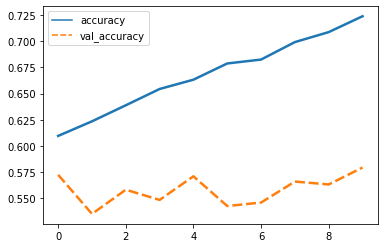

In [51]:
h3, r3 = fit_test_save_hist(model, bs=256, ep=10, fnm='fer45.json', fnw='fer45.h5')

In [54]:
model = get_model_v40(p_size=(2,2,2,2,0), dropout=(0,0.5,0.0,0.5,0))
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
batch_normalization_65 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 12, 12, 64)      

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 52s 2ms/step - loss: 1.8540 - accuracy: 0.2522 - val_loss: 1.9681 - val_accuracy: 0.1691
Epoch 2/10
28709/28709 [==============================] - 51s 2ms/step - loss: 1.6948 - accuracy: 0.3271 - val_loss: 2.0636 - val_accuracy: 0.1936
Epoch 3/10
28709/28709 [==============================] - 50s 2ms/step - loss: 1.6109 - accuracy: 0.3717 - val_loss: 2.0258 - val_accuracy: 0.2995
Epoch 4/10
28709/28709 [==============================] - 51s 2ms/step - loss: 1.5352 - accuracy: 0.4033 - val_loss: 2.0684 - val_accuracy: 0.1733
Epoch 5/10
28709/28709 [==============================] - 51s 2ms/step - loss: 1.4796 - accuracy: 0.4252 - val_loss: 1.9119 - val_accuracy: 0.2655
Epoch 6/10
28709/28709 [==============================] - 50s 2ms/step - loss: 1.4365 - accuracy: 0.4444 - val_loss: 1.7680 - val_accuracy: 0.3213
Epoch

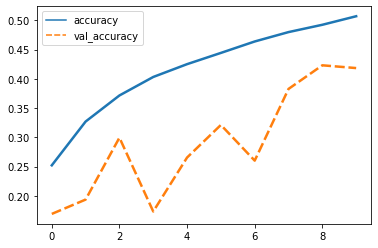

In [55]:
h2, r2 = fit_test_save_hist(model, bs=512, ep=10, fnm='fer46.json', fnw='fer46.h5')

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 52s 2ms/step - loss: 1.2843 - accuracy: 0.5066 - val_loss: 1.2911 - val_accuracy: 0.5043
Epoch 2/10
28709/28709 [==============================] - 50s 2ms/step - loss: 1.2486 - accuracy: 0.5191 - val_loss: 1.3396 - val_accuracy: 0.4937
Epoch 3/10
28709/28709 [==============================] - 49s 2ms/step - loss: 1.2190 - accuracy: 0.5345 - val_loss: 1.2648 - val_accuracy: 0.5222
Epoch 4/10
28709/28709 [==============================] - 51s 2ms/step - loss: 1.1864 - accuracy: 0.5453 - val_loss: 1.2502 - val_accuracy: 0.5344
Epoch 5/10
28709/28709 [==============================] - 51s 2ms/step - loss: 1.1585 - accuracy: 0.5584 - val_loss: 1.1936 - val_accuracy: 0.5425
Epoch 6/10
28709/28709 [==============================] - 51s 2ms/step - loss: 1.1351 - accuracy: 0.5691 - val_loss: 1.2029 - val_accuracy: 0.5405
Epoch

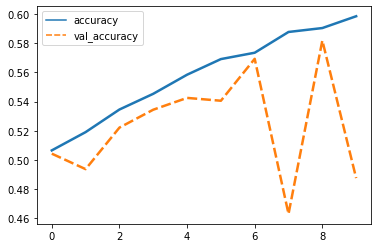

In [56]:
h3, r3 = fit_test_save_hist(model, bs=256, ep=10, fnm='fer45.json', fnw='fer45.h5')

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 50s 2ms/step - loss: 1.0294 - accuracy: 0.6099 - val_loss: 1.1406 - val_accuracy: 0.5851
Epoch 2/10
28709/28709 [==============================] - 51s 2ms/step - loss: 1.0075 - accuracy: 0.6202 - val_loss: 1.1212 - val_accuracy: 0.5815
Epoch 3/10
28709/28709 [==============================] - 52s 2ms/step - loss: 0.9939 - accuracy: 0.6260 - val_loss: 1.1774 - val_accuracy: 0.5587
Epoch 4/10
28709/28709 [==============================] - 50s 2ms/step - loss: 0.9741 - accuracy: 0.6325 - val_loss: 1.1187 - val_accuracy: 0.5854
Epoch 5/10
28709/28709 [==============================] - 48s 2ms/step - loss: 0.9535 - accuracy: 0.6416 - val_loss: 1.1275 - val_accuracy: 0.5837
Epoch 6/10
28709/28709 [==============================] - 49s 2ms/step - loss: 0.9431 - accuracy: 0.6439 - val_loss: 1.1293 - val_accuracy: 0.5773
Epoch

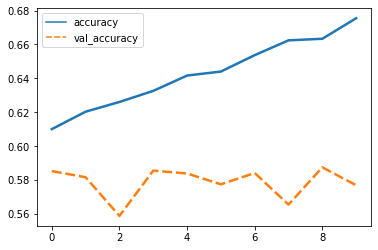

In [57]:
h4, r4 = fit_test_save_hist(model, bs=256, ep=10, fnm='fer46.json', fnw='fer46.h5')

In [66]:
model = get_model_v40(num_filtre=(16, 32, 64, 128, 256), lf=256, p_size=(2,2,2,2,0), dropout=(0.0, 0.50, 0.0, 0.5, 0.0))
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_121 (Conv2D)          (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 24, 24, 32)        4640      
_________________________________________________________________
batch_normalization_97 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_107 (MaxPoolin (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 12, 12, 64)      

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 53s 2ms/step - loss: 1.8006 - accuracy: 0.2725 - val_loss: 2.1747 - val_accuracy: 0.2494
Epoch 2/10
28709/28709 [==============================] - 54s 2ms/step - loss: 1.6279 - accuracy: 0.3572 - val_loss: 2.0094 - val_accuracy: 0.3004
Epoch 3/10
28709/28709 [==============================] - 51s 2ms/step - loss: 1.5291 - accuracy: 0.4043 - val_loss: 1.7483 - val_accuracy: 0.3045
Epoch 4/10
28709/28709 [==============================] - 51s 2ms/step - loss: 1.4438 - accuracy: 0.4414 - val_loss: 1.5516 - val_accuracy: 0.3906
Epoch 5/10
28709/28709 [==============================] - 52s 2ms/step - loss: 1.3889 - accuracy: 0.4632 - val_loss: 1.4631 - val_accuracy: 0.4135
Epoch 6/10
28709/28709 [==============================] - 52s 2ms/step - loss: 1.3499 - accuracy: 0.4804 - val_loss: 1.3930 - val_accuracy: 0.4570
Epoch

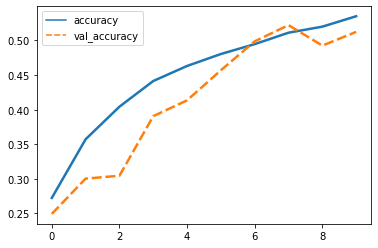

In [67]:
h5, r5 = fit_test_save_hist(model, bs=256, ep=10, fnm='fer47.json', fnw='fer47.h5')

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 54s 2ms/step - loss: 1.1949 - accuracy: 0.5400 - val_loss: 1.2731 - val_accuracy: 0.5333
Epoch 2/10
28709/28709 [==============================] - 54s 2ms/step - loss: 1.1588 - accuracy: 0.5588 - val_loss: 1.1948 - val_accuracy: 0.5442
Epoch 3/10
28709/28709 [==============================] - 53s 2ms/step - loss: 1.1478 - accuracy: 0.5626 - val_loss: 1.1995 - val_accuracy: 0.5458
Epoch 4/10
28709/28709 [==============================] - 56s 2ms/step - loss: 1.1255 - accuracy: 0.5731 - val_loss: 1.2427 - val_accuracy: 0.5325
Epoch 5/10
28709/28709 [==============================] - 60s 2ms/step - loss: 1.0971 - accuracy: 0.5798 - val_loss: 1.1720 - val_accuracy: 0.5531
Epoch 6/10
28709/28709 [==============================] - 57s 2ms/step - loss: 1.0768 - accuracy: 0.5922 - val_loss: 1.1783 - val_accuracy: 0.5603
Epoch

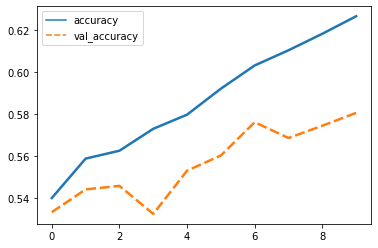

In [68]:
h6, r6 = fit_test_save_hist(model, bs=256, ep=10, fnm='fer48.json', fnw='fer48.h5')

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 56s 2ms/step - loss: 0.9747 - accuracy: 0.6314 - val_loss: 1.1480 - val_accuracy: 0.5690
Epoch 2/10
28709/28709 [==============================] - 53s 2ms/step - loss: 0.9428 - accuracy: 0.6470 - val_loss: 1.1406 - val_accuracy: 0.5667
Epoch 3/10
28709/28709 [==============================] - 53s 2ms/step - loss: 0.9268 - accuracy: 0.6531 - val_loss: 1.2357 - val_accuracy: 0.5595
Epoch 4/10
28709/28709 [==============================] - 54s 2ms/step - loss: 0.9035 - accuracy: 0.6601 - val_loss: 1.1467 - val_accuracy: 0.5843
Epoch 5/10
28709/28709 [==============================] - 53s 2ms/step - loss: 0.8764 - accuracy: 0.6737 - val_loss: 1.3373 - val_accuracy: 0.5495
Epoch 6/10
28709/28709 [==============================] - 53s 2ms/step - loss: 0.8520 - accuracy: 0.6833 - val_loss: 1.1822 - val_accuracy: 0.5737
Epoch

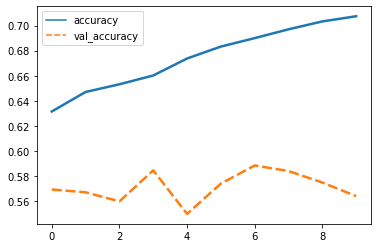

In [69]:
h7, r7 = fit_test_save_hist(model, bs=256, ep=10, fnm='fer49.json', fnw='fer49.h5')

In [12]:
model = get_model_v20()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 512)       5120      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 512)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 512)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       589952    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       512       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 128)      

<h3>Appliquer la fonction <i style="color:blue">fit_test_save_hist</i></h3>

<p>Le processu est interrompu voltairement car chaque epoch prend plus d'une heure de temps</p>

In [ ]:
#history, test_result = fit_test_save_hist(model, fnm='fer20.json', fnw='fer20.h5')

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/30
28709/28709 [==============================] - 6846s 238ms/step - loss: 2.0149 - accuracy: 0.2355 - val_loss: 3.0117 - val_accuracy: 0.0371
Epoch 2/30
28709/28709 [==============================] - 4642s 162ms/step - loss: 1.8468 - accuracy: 0.2509 - val_loss: 2.2439 - val_accuracy: 0.1452
Epoch 3/30
28709/28709 [==============================] - 3845s 134ms/step - loss: 1.8258 - accuracy: 0.2507 - val_loss: 2.2182 - val_accuracy: 0.2343
Epoch 4/30
28709/28709 [==============================] - 3813s 133ms/step - loss: 1.8172 - accuracy: 0.2510 - val_loss: 1.9328 - val_accuracy: 0.2173
Epoch 5/30
 6400/28709 [=====>........................] - ETA: 46:39 - loss: 1.8125 - accuracy: 0.2469

<h3>1ere appel de la fonction d'apprentissage</h3>

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/30
28709/28709 [==============================] - 718s 25ms/step - loss: 2.0583 - accuracy: 0.1976 - val_loss: 2.0180 - val_accuracy: 0.2494
Epoch 2/30
28709/28709 [==============================] - 703s 25ms/step - loss: 1.8429 - accuracy: 0.2379 - val_loss: 1.8616 - val_accuracy: 0.2449
Epoch 3/30
28709/28709 [==============================] - 706s 25ms/step - loss: 1.8243 - accuracy: 0.2452 - val_loss: 1.8031 - val_accuracy: 0.2494
Epoch 4/30
28709/28709 [==============================] - 705s 25ms/step - loss: 1.8166 - accuracy: 0.2487 - val_loss: 1.8717 - val_accuracy: 0.2494
Epoch 5/30
28709/28709 [==============================] - 705s 25ms/step - loss: 1.8077 - accuracy: 0.2519 - val_loss: 1.8184 - val_accuracy: 0.2513
Epoch 6/30
28709/28709 [==============================] - 705s 25ms/step - loss: 1.8007 - accuracy: 0.2519 - val_loss: 1.7930 - val_accuracy: 

C:\Users\jeang\anaconda3\envs\rl_env\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


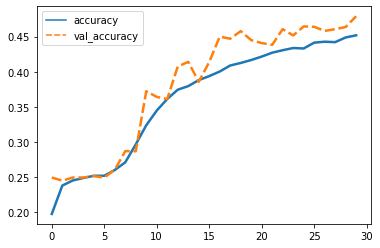

In [13]:
history, test_result = fit_test_save_hist(model, fnm='fer20.json', fnw='fer20.h5')

In [14]:
show_confusion_matrix(model)

C:\Users\jeang\anaconda3\envs\rl_env\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


,0,1,2,3,4,5,6
0,0.38,0.07,0.29,0.06,0.10,0.03,0.06
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.23,0.01,0.31,0.07,0.09,0.23,0.06
3,0.06,0.01,0.06,0.68,0.07,0.03,0.09
4,0.21,0.03,0.16,0.06,0.34,0.02,0.17
5,0.05,0.00,0.22,0.03,0.02,0.68,0.01
6,0.16,0.02,0.16,0.02,0.26,0.03,0.36


<h3>2eme appel de la fonction d'apprentissage</h3>
<p>Le nombre d'epoche etait change a 10<br>
Ceci nous permet de ne pas tomber dans un processu trop couteux<br>
S'il a besoin plus d'epoch pour apprentissage, on peut appeler la meme fonction</p>

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 712s 25ms/step - loss: 1.3693 - accuracy: 0.4537 - val_loss: 1.3133 - val_accuracy: 0.4801
Epoch 2/10
28709/28709 [==============================] - 698s 24ms/step - loss: 1.3709 - accuracy: 0.4586 - val_loss: 1.2645 - val_accuracy: 0.4943
Epoch 3/10
28709/28709 [==============================] - 693s 24ms/step - loss: 1.3558 - accuracy: 0.4682 - val_loss: 1.2605 - val_accuracy: 0.4915
Epoch 4/10
28709/28709 [==============================] - 695s 24ms/step - loss: 1.3541 - accuracy: 0.4694 - val_loss: 1.2485 - val_accuracy: 0.5174
Epoch 5/10
28709/28709 [==============================] - 696s 24ms/step - loss: 1.3398 - accuracy: 0.4752 - val_loss: 1.2748 - val_accuracy: 0.5063
Epoch 6/10
28709/28709 [==============================] - 695s 24ms/step - loss: 1.3416 - accuracy: 0.4761 - val_loss: 1.2400 - val_accuracy: 

C:\Users\jeang\anaconda3\envs\rl_env\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


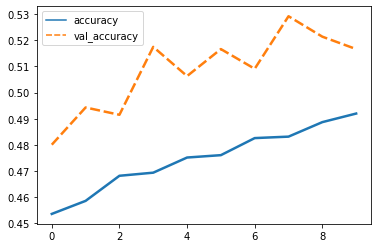

In [15]:
h1, r1 = fit_test_save_hist(model, ep=10, fnm='fer21.json', fnw='fer21.h5')

<h3>Nouvel model de <i style="color:blue">fonction get_model_v20</i></h3>
<p>La valeur de dropout est modifiee pour controler le probleme de sous apprentissage</p>

In [17]:
model = get_model_v20(dropout=(0.25,0.25,0.25,0.30,0.30))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 512)       5120      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 512)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 24, 24, 512)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 128)       589952    
_________________________________________________________________
batch_normalization_5 (Batch (None, 24, 24, 128)       512       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 12, 12, 128)      

<h3>3eme appel de la fonction d'apprentissage</h3>
<p>C'est un nouvel modele car la avleur dropout est change en raison de sous-apprentissage<br>
Ceci nous permet de ne pas tomber dans un processu trop couteux<br>
S'il a besoin plus d'epoch pour apprentissage, on peut appeler la meme fonction</p>

In [ ]:
h3, r3 = fit_test_save_hist(model, fnm='fer23.json', fnw='fer23.h5')

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/30
28709/28709 [==============================] - 704s 25ms/step - loss: 1.9283 - accuracy: 0.2053 - val_loss: 1.8261 - val_accuracy: 0.2494
Epoch 2/30
28709/28709 [==============================] - 698s 24ms/step - loss: 1.8191 - accuracy: 0.2418 - val_loss: 1.7900 - val_accuracy: 0.2625
Epoch 3/30
28709/28709 [==============================] - 702s 24ms/step - loss: 1.7973 - accuracy: 0.2532 - val_loss: 1.7667 - val_accuracy: 0.2692
Epoch 4/30
28709/28709 [==============================] - 699s 24ms/step - loss: 1.7537 - accuracy: 0.2844 - val_loss: 1.8027 - val_accuracy: 0.2555
Epoch 5/30
28709/28709 [==============================] - 699s 24ms/step - loss: 1.6784 - accuracy: 0.3317 - val_loss: 1.7203 - val_accuracy: 0.2795
Epoch 6/30
28709/28709 [==============================] - 697s 24ms/step - loss: 1.6061 - accuracy: 0.3676 - val_loss: 1.5110 - val_accuracy: 

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 711s 25ms/step - loss: 2.1001 - accuracy: 0.1928 - val_loss: 1.8376 - val_accuracy: 0.2154
Epoch 2/10
28709/28709 [==============================] - 704s 25ms/step - loss: 1.8485 - accuracy: 0.2302 - val_loss: 1.8247 - val_accuracy: 0.2274
Epoch 3/10
28709/28709 [==============================] - 701s 24ms/step - loss: 1.8208 - accuracy: 0.2434 - val_loss: 1.7945 - val_accuracy: 0.2566
Epoch 4/10
28709/28709 [==============================] - 701s 24ms/step - loss: 1.8112 - accuracy: 0.2483 - val_loss: 1.7877 - val_accuracy: 0.2583
Epoch 5/10
28709/28709 [==============================] - 702s 24ms/step - loss: 1.8032 - accuracy: 0.2547 - val_loss: 1.7862 - val_accuracy: 0.2508
Epoch 6/10
28709/28709 [==============================] - 707s 25ms/step - loss: 1.7974 - accuracy: 0.2547 - val_loss: 1.7743 - val_accuracy: 

C:\Users\jeang\anaconda3\envs\rl_env\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


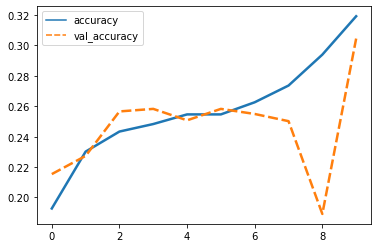

In [17]:
history, test_result = fit_test_save_hist(model, ep=10, fnm='fer20.json', fnw='fer20.h5')

<h3>2eme appel de la fonction d'apprentissage</h3>
<p>Le nombre d'epoche etait change a 10<br>
Ceci nous permet de ne pas tomber dans un processu trop couteux<br>
S'il a besoin plus d'epoch pour apprentissage, on peut appeler la meme fonction</p>

In [ ]:
h1, r1 = fit_test_save_hist(model, ep=10, fnm='fer21.json', fnw='fer21.h5')

Fitting the model with new train set and new validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/10
10880/28709 [==========>...................] - ETA: 7:16 - loss: 1.6465 - accuracy: 0.3461

In [ ]:
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, 
                                                                  sampler=RandomOverSampler(), 
                                                                  batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

In [ ]:
datagen = ImageDataGenerator(...) # define your data augmentation
bgen = BalancedDataGenerator(x, y, datagen, batch_size=32)
steps_per_epoch = bgen.steps_per_epoch

In [ ]:
y_gen = [bgen.__getitem__(0)[1] for i in range(steps_per_epoch)]
print(np.unique(y_gen, return_counts=True))

In [ ]:
x, y = ... # load your data
datagen = ImageDataGenerator()
balanced_gen = BalancedDataGenerator(x, y, datagen, batch_size=32)
steps_per_epoch = balanced_gen.steps_per_epoch
model = ... # define your model
model.compile(...) # define your compile parameters
model.fit_generator(balanced_gen, steps_per_epoch, ...)